# AlexNet for Food-101

## Introduction
This project implements [AlexNet](https://en.wikipedia.org/wiki/AlexNet), a deep convolutional neural network, to classify images from the [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) dataset. Instead of fine-tuning a pre-trained model, we build the model and train it from scratch. The original AlexNet model was trained on [ImageNet](https://www.image-net.org/) and achieved groundbreaking results, making it a strong candidate for transfer learning tasks like food classification.

---

## Background

### AlexNet
[AlexNet](https://en.wikipedia.org/wiki/AlexNet) is a pioneering convolutional neural network architecture introduced in 2012 by Alex Krizhevsky, Geoffrey Hinton, and Ilya Sutskever. It demonstrated the power of deep learning by winning the [ImageNet Large Scale Visual Recognition Challenge (ILSVRC)](https://www.image-net.org/challenges/LSVRC/) in 2012. The architecture (see **Figure 1**) consists of:
- **Five convolutional layers** followed by **three fully connected layers**.
- **ReLU activations** to introduce non-linearity, improving the network's capacity to model complex patterns.
- **Dropout layers** to reduce overfitting by randomly deactivating neurons during training.
- **Overlapping max-pooling** layers to improve feature extraction after key convolutional layers.
  
AlexNet is designed for images with a resolution of **224x224**, requiring datasets like Food-101 (with 512x512 images) to be resized during preprocessing.

---

### Food-101
[Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) is a widely used image dataset for food classification, introduced by Lukas Bossard et al. in 2014. The dataset contains:
- **101,000 images** across **101 food categories**, ranging from burgers to sushi.
- **Training Set:** 750 images per category.
- **Test Set:** 250 images per category.

The dataset introduces real-world challenges such as:
- **Occlusions** (where parts of the food are hidden).
- **Varying lighting conditions** (images taken in different environments).
- **Mixed dishes** (images featuring more than one type of food).

Training images are partially cleaned, while test images remain uncleaned to evaluate the model's ability to generalize.

---

### Modifications
Our implementation of the AlexNet architecture remains largely faithful to the original design but includes the following adjustments:
1. **Data Transformation:**
   - The preprocessing pipeline has been tailored to accommodate the Food-101 dataset's characteristics, including resizing images to 224x224.
   
2. **Weight Initialization:**
   - While the original AlexNet used a specific weight initialization strategy, our implementation defaults to **randomized initialization** of weights and biases. 
   - The original hardcoded initialization is included in the model definition for reference but is not executed by default.

These modifications make the model better suited to the unique challenges posed by the Food-101 dataset while maintaining compatibility with modern PyTorch workflows.

---

<div style="text-align: center;">
        <img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/AlexNet_block_diagram.svg" alt="AlexNet Architecture" />
    <p style="text-align: center;"><strong>Figure 1</strong>: AlexNet Architecture</p>
</div>

By Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J. - [Deep Learning D2L](https://github.com/d2l-ai/d2l-en), CC BY-SA 4.0, [Wikimedia Commons](https://commons.wikimedia.org/w/index.php?curid=152265712).

## Setup

### Imports

In [1]:
import os
import shutil
import requests
import numpy as np
import platform
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder


Matplotlib created a temporary cache directory at /tmp/matplotlib-vgmapxxg because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Config

In [21]:
EPOCHS = 500
STARTING_EPOCH = 0
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
MOMENTUM=0.9
DECAY=0.005
STEP_SIZE=30
GAMMA=0.1
VALIDATION_FRQ = 5
PATH = './AlexNet.pth'
BASE_DIR = "./data/food-101/"
IMAGES_DIR = os.path.join(BASE_DIR, "images")
META_DIR = os.path.join(BASE_DIR, "meta")
URL = "https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
OUTPUT_PATH = "./data/food-101.tar.gz"


### Check and Setup CUDA

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(DEVICE)

cuda


### Utility Functions

In [4]:
def download_file(url, output_path):
    # Check if the file is already downloaded
    if os.path.exists(output_path):
        print(f"File already downloaded: {output_path}")
        return
    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    with open(output_path, 'wb') as file, tqdm(
        desc=output_path,
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            file.write(data)
            bar.update(len(data))
    print(f"Downloaded file to: {output_path}")
    
def organize_dataset():
    # Check if the dataset is already organized
    if os.path.exists(os.path.join(BASE_DIR, "train")) and os.path.exists(os.path.join(BASE_DIR, "test")):
        print("Dataset already organized.")
        return
    print("Organizing dataset ...")
    for split in ["train", "test"]:
        split_dir = os.path.join(BASE_DIR, split)
        os.makedirs(split_dir, exist_ok=True)

        with open(os.path.join(META_DIR, f"{split}.txt")) as f:
            for line in f:
                class_name, image_name = line.strip().split("/")
                class_dir = os.path.join(split_dir, class_name)
                os.makedirs(class_dir, exist_ok=True)
                source = os.path.join(IMAGES_DIR, class_name, f"{image_name}.jpg")
                destination = os.path.join(class_dir, f"{image_name}.jpg")
                shutil.move(source, destination)
    print("Dataset organized successfully.")

def get_food101():
    # Check if the dataset directory exists
    if not os.path.exists(BASE_DIR):
        os.makedirs(BASE_DIR, exist_ok=True)

    # Download the dataset
    download_file(URL, OUTPUT_PATH)

    # Extract the dataset if not already extracted
    if not os.path.exists(IMAGES_DIR):
        print("Extracting dataset...")
        os.system(f"tar --strip-components=1 -xvzf {OUTPUT_PATH} -C {BASE_DIR}")
    else:
        print("Dataset already extracted.")

    # Organize the dataset into train/test directories
    organize_dataset()

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Turn off the axis for better visualization
    plt.show()

## Data Preprocessing

### Define transformations

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Download Food Dataset
Download the food-101 data and organize it into traing and test sets

In [6]:
get_food101()

File already downloaded: ./data/food-101.tar.gz
Dataset already extracted.
Dataset already organized.


### Load the Dataset
Setup custom data loader for the food-101 data 

In [7]:
full_train_dataset = ImageFolder(root=os.path.join(BASE_DIR, "train"), transform=train_transforms)
test_dataset = ImageFolder(root=os.path.join(BASE_DIR,"test"), transform=test_transforms)
classes = full_train_dataset.classes

#### Split into training and validation sets (e.g., 80% train, 20% validation)

In [8]:
train_size = int(0.8 * len(full_train_dataset))  # 80% for training
val_size = len(full_train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

### Validation dataset uses val_transforms (optional but recommended)

In [9]:
val_dataset.dataset.transform = test_transforms  # Apply val_transforms to validation set

### Create data loaders

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


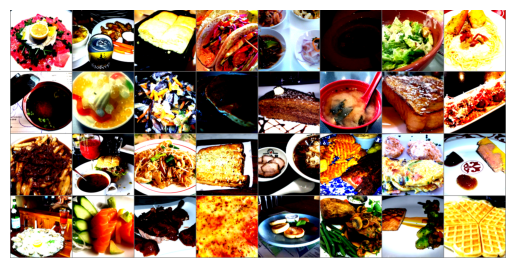

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))


### CNN Model

In [12]:
class AlexNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AlexNet, self).__init__() 
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels, 96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 6 * 6, 4069)
        self.fc2 = nn.Linear(4069, 4069)
        self.fc3 = nn.Linear(4069, num_classes)

        # Other
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm = nn.LocalResponseNorm(size=5, k=2)
        self.droput = nn.Dropout(0.5)
        self.relu = nn.ReLU()

        # Initialize the weights
        #self._init_weights()

    def forward(self, x):
        x = self.maxpool(self.norm(self.relu(self.conv1(x))))  # (B, 96, 27, 27)
        x = self.maxpool(self.norm(self.relu(self.conv2(x))))  # (B, 256, 13, 13)
        x = self.relu(self.conv3(x))                           # (B, 384, 13, 13)
        x = self.relu(self.conv4(x))                           # (B, 384, 13, 13)
        x = self.maxpool(self.relu(self.conv5(x)))             # (B, 256, 6, 6)
        x = self.flatten(x)                                    # (B, 9216)
        x = self.droput(self.relu(self.fc1(x)))                # (B, 4096)
        x = self.droput(self.relu(self.fc2(x)))                # (B, 4096)
        x = self.fc3(x)                                        # (B, num_classes)
        return x

    def _init_weights(self):
        bias_1 = [1, 3, 4, 5, 6, 7] # Layers with bias initialized with 1

        for i, layer in enumerate(self.modules()):
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                if i in bias_1:
                    # Initialize bias with 1
                    nn.init.constant_(layer.bias, 1)
                else:
                    # Initialize bias with 0
                    nn.init.constant_(layer.bias, 0)

                # Initialize the weights from a zero-mean Gaussian 
                # distributition with std=0.01
                nn.init.normal_(layer.weight, mean=0, std=0.01)

In [22]:
model = AlexNet(in_channels = 3, num_classes=len(classes)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=DECAY)
n_total_steps = len(train_loader)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

### Load the model if it exists

In [16]:
best_val_loss = float('inf')  # Track the best validation loss for saving checkpoints
if os.path.exists(PATH):
    print("Found a model to start off...")

    # Load the checkpoint
    checkpoint = torch.load(PATH)

    # Restore the model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Restore other information
    STARTING_EPOCH = checkpoint['epoch']
    best_val_loss = checkpoint['loss']
    print(f"Checkpoint loaded: Start Epoch = {STARTING_EPOCH}, Loss = {best_val_loss:.4f}")

Found a model to start off...
Checkpoint loaded: Start Epoch = 26, Loss = 2.7746


#### Training loop with validation and checkpoints

In [ ]:

for epoch in tqdm(range(STARTING_EPOCH,EPOCHS)):
    # Training phase
    model.train()  # Set model to training mode
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log every 2000 steps
        if (i + 1) % 2000 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{EPOCHS}] Training Loss: {avg_train_loss:.4f}')
    scheduler.step()
    if not epoch % VALIDATION_FRQ:
        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for images, labels in val_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{EPOCHS}] Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

        # Save checkpoint if validation loss improves
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving checkpoint.")
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_val_loss
            }, PATH)
        else:
            print("No improvement in validation loss.")


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/500] Training Loss: 1.5100


  0%|          | 1/500 [02:40<22:12:12, 160.19s/it]

Epoch [1/500] Validation Loss: 3.0171, Accuracy: 30.50%
No improvement in validation loss.


  0%|          | 2/500 [04:49<19:37:51, 141.91s/it]

Epoch [2/500] Training Loss: 1.2309


  1%|          | 3/500 [07:01<18:57:22, 137.31s/it]

Epoch [3/500] Training Loss: 1.1030


  1%|          | 4/500 [09:09<18:26:51, 133.89s/it]

Epoch [4/500] Training Loss: 1.0072


  1%|          | 5/500 [11:19<18:10:58, 132.24s/it]

Epoch [5/500] Training Loss: 0.9450
Epoch [6/500] Training Loss: 0.8808


  1%|          | 6/500 [14:08<19:52:18, 144.82s/it]

Epoch [6/500] Validation Loss: 2.9837, Accuracy: 32.50%
No improvement in validation loss.


  1%|▏         | 7/500 [16:18<19:09:40, 139.92s/it]

Epoch [7/500] Training Loss: 0.8259


  2%|▏         | 8/500 [18:25<18:34:52, 135.96s/it]

Epoch [8/500] Training Loss: 0.7782


  2%|▏         | 9/500 [20:36<18:19:07, 134.31s/it]

Epoch [9/500] Training Loss: 0.7392


  2%|▏         | 10/500 [22:43<17:57:42, 131.96s/it]

Epoch [10/500] Training Loss: 0.6997
Epoch [11/500] Training Loss: 0.6599


  2%|▏         | 11/500 [25:29<19:21:27, 142.51s/it]

Epoch [11/500] Validation Loss: 3.0260, Accuracy: 33.04%
No improvement in validation loss.


  2%|▏         | 12/500 [27:34<18:36:15, 137.25s/it]

Epoch [12/500] Training Loss: 0.6195


  3%|▎         | 13/500 [29:40<18:05:41, 133.76s/it]

Epoch [13/500] Training Loss: 0.5957


  3%|▎         | 14/500 [31:48<17:50:15, 132.13s/it]

Epoch [14/500] Training Loss: 0.5631


  3%|▎         | 15/500 [33:53<17:28:59, 129.77s/it]

Epoch [15/500] Training Loss: 0.5397
Epoch [16/500] Training Loss: 0.5135


  3%|▎         | 16/500 [36:37<18:50:17, 140.12s/it]

Epoch [16/500] Validation Loss: 3.0921, Accuracy: 33.31%
No improvement in validation loss.


  3%|▎         | 17/500 [38:46<18:20:34, 136.72s/it]

Epoch [17/500] Training Loss: 0.4874


  4%|▎         | 18/500 [40:51<17:51:02, 133.32s/it]

Epoch [18/500] Training Loss: 0.4649


  4%|▍         | 19/500 [42:59<17:35:52, 131.71s/it]

Epoch [19/500] Training Loss: 0.4520


  4%|▍         | 20/500 [45:07<17:23:51, 130.48s/it]

Epoch [20/500] Training Loss: 0.4269
Epoch [21/500] Training Loss: 0.4047


  4%|▍         | 21/500 [47:56<18:56:14, 142.33s/it]

Epoch [21/500] Validation Loss: 3.1654, Accuracy: 33.50%
No improvement in validation loss.


  4%|▍         | 22/500 [50:05<18:20:06, 138.09s/it]

Epoch [22/500] Training Loss: 0.3943


  5%|▍         | 23/500 [52:13<17:54:14, 135.13s/it]

Epoch [23/500] Training Loss: 0.3743


  5%|▍         | 24/500 [54:22<17:37:46, 133.33s/it]

Epoch [24/500] Training Loss: 0.3572


### Save the final model

In [ ]:
print('Finished Training')
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_val_loss
}, PATH)


In [ ]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(classes))]
    n_class_samples = [0 for i in range(len(classes))]
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')
